In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from dipole import dipole, dipole_map, spherical_to_cartesian, xyz_to_thetaphi

**GOAL:** Explore the least-squares fit to the dipole in Quaia.

Fit to:
- CMB dipole (i.e. E-B estimate in CMB direction)
    - with feature maps
    - without feature maps
- full dipole vector (i.e. three orthogonal templates)
    - with feature maps
    - without feature maps
    - without feature maps, only where completeness > 0.9
    - without feature maps, using $\sim$same mask as Secrest

### load Quaia catalog, selection function, and feature maps

In [3]:
# Quaia map
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
G = 20.5
map_quaia = tools.load_catalog_as_map(f'/scratch/aew492/quasars/catalogs/catalog_G{G}.fits', frame='icrs')

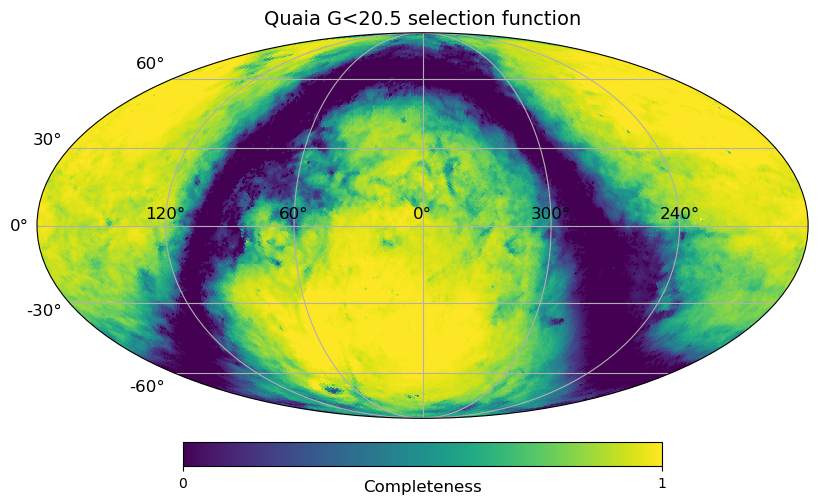

In [4]:
# selection function
selfunc = tools.flatten_map(Table.read(
    f'/scratch/aew492/quasars/maps/selection_function_NSIDE{NSIDE}_G{G}.fits', format='fits'))
tools.plot_map(selfunc, title=f'Quaia G<{G} selection function', unit='Completeness')

In [5]:
# feature maps
maps_forsel = []
map_names = ['dust', 'stars', 'm10', 'mcs']
for map_name in map_names:
    maps_forsel.append(np.load(f'/scratch/aew492/quasars/maps/map_{map_name}_NSIDE{NSIDE}.npy'))

In [6]:
# expected CMB dipole
cmb_dipamp = 0.0047  # amplitude from Ellis-Baldwin approximation (Quaia's mean alpha and x)
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
print(cmb_dipdir.icrs)
cmb_amps = np.array([0., *spherical_to_cartesian(r=cmb_dipamp,
                                             theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                             phi=cmb_dipdir.icrs.ra.rad)])
expected_map = dipole_map(cmb_amps, NSIDE) # match NSIDE with Quaia map

<SkyCoord (ICRS): (ra, dec) in deg
    (167.78661173, -7.14538872)>


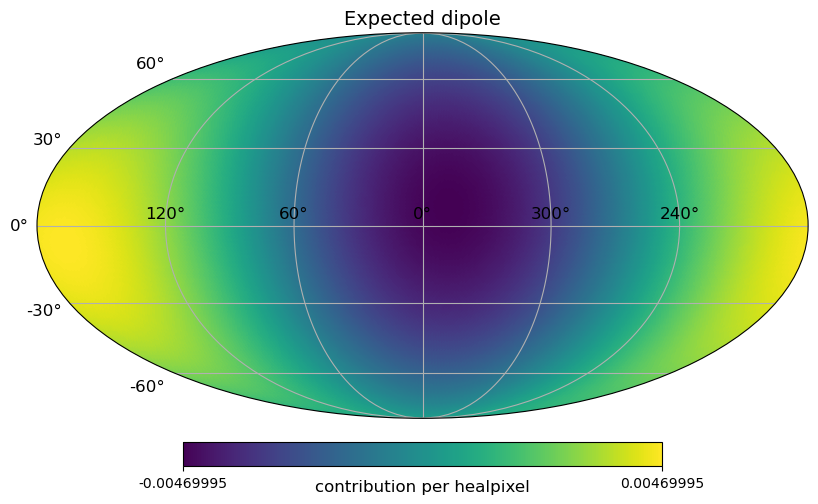

In [7]:
tools.plot_map(expected_map, title='Expected dipole', unit='contribution per healpixel')

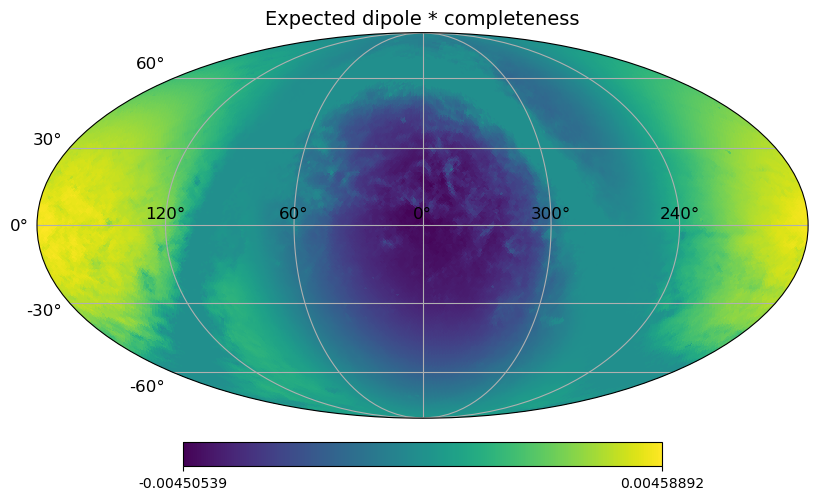

In [8]:
tools.plot_map(selfunc * expected_map, title='Expected dipole * completeness')

### fit to CMB dipole and feature maps

Weight by completeness.

(Note we previously tried `Cinv = 41 * selfunc`)

** 41 comes from the mean qso density when weighted by completeness.

In [9]:
# weights
"""
WARNING: "magic number"
"""
Cinv = 1. / np.clip(41 * selfunc, 1., None)  # set min value to 1

In [10]:
# construct design matrix: (1, expected dipole, feature maps)
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))
for map_ in maps_forsel:
    A = np.column_stack((A, map_))  
A.shape

(49152, 6)

In [11]:
# perform the regression
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia, A, Cinv)

In [12]:
# uncertainties on the best-fit pars
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [13]:
# print out results
x_names = np.append(['completeness','CMB dipole * comp.'], map_names)
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.6f}'
            if i >= 3:
                x = f'{float(entry):.3e}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	41.046448       	0.041658        	
CMB dipole * comp.	107.108232      	12.393752       	
dust            	4.623e-03       	1.538e-03       	
stars           	2.038e-05       	8.593e-06       	
m10             	-5.721e-03      	7.677e-04       	
mcs             	1.385e-04       	1.718e-04       	


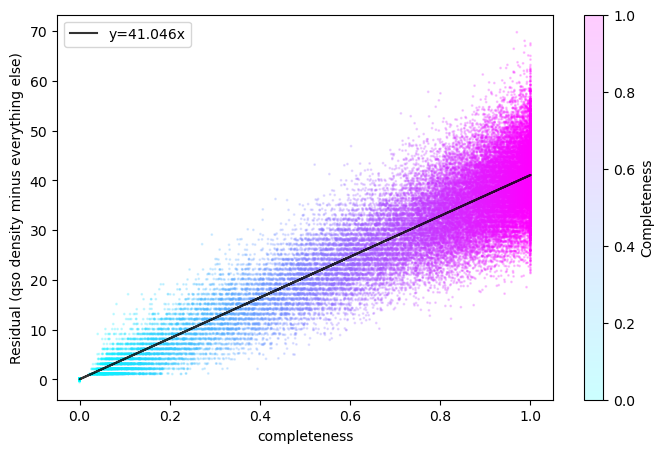

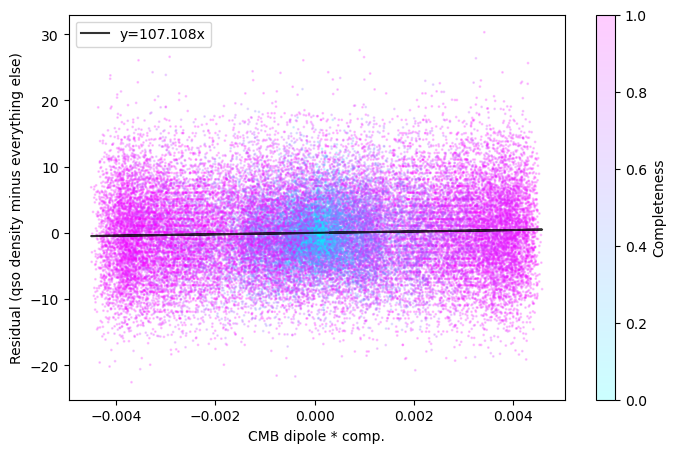

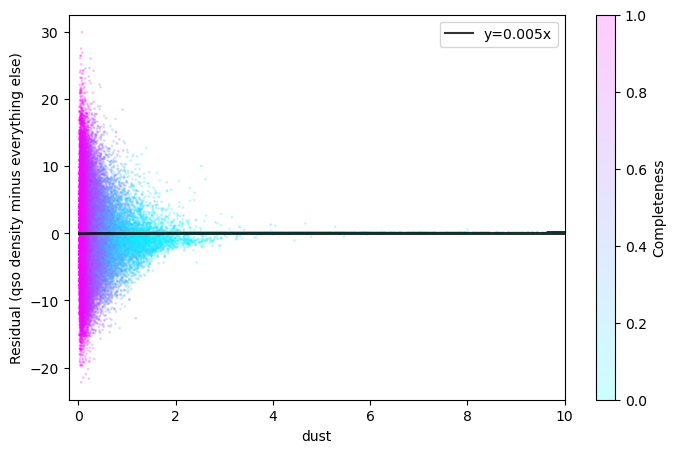

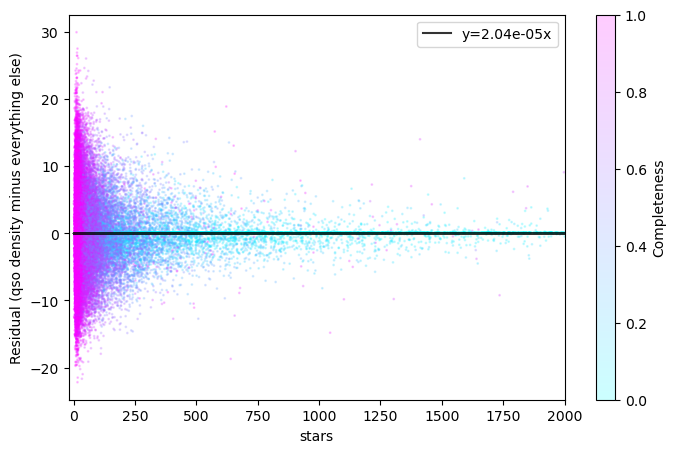

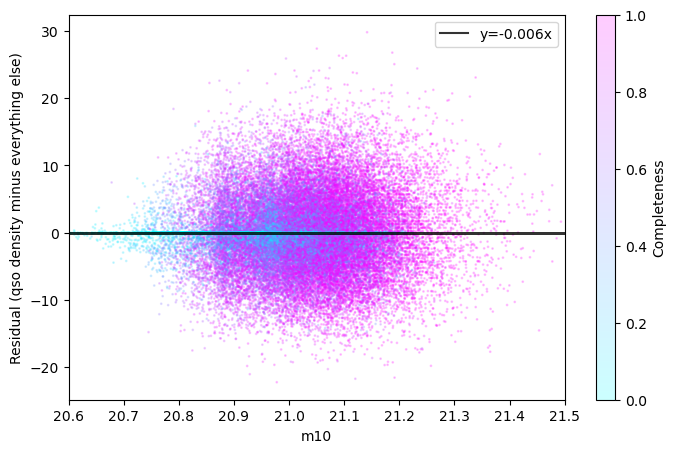

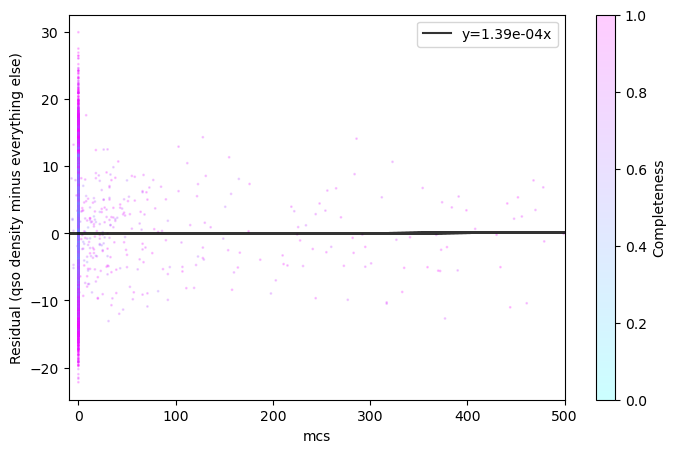

In [14]:
xlims = [(None,None), (None,None), (-0.2,10), (-20, 2e3), (20.6,21.5), (-10,500)]
for i, slope in enumerate(bestfit_pars):
    pars_copy = bestfit_pars.copy()
    pars_copy[i] = 0
    plot_y = map_quaia - A @ pars_copy
    if x_names[i]=='stars' or x_names[i]=='mcs':
        label = f'y={slope:.2e}x'
    else:
        label = f'y={slope:.3f}x'
    fig, ax = plt.subplots(figsize=(8,5))
    s = ax.scatter(A[:,i], plot_y, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
    ax.plot(A[:,i], slope * A[:,i], color='k', alpha=0.8, label=label, zorder=100)
    ax.set_xlim(xlims[i])
    ax.set_xlabel(x_names[i])
    ax.set_ylabel('Residual (qso density minus everything else)')
    # ax.set_title('Dipole fit to Quaia catalog')
    ax.legend()
    fig.colorbar(s, label='Completeness')

#### helper function

In [15]:
def lstsqfit(full_vector=True, fit_everything=False, plots=False, idx=np.full(len(map_quaia), True)):
    
    # construct design matrix
    if full_vector:
        print("fitting to full dipole vector")
        template_amps = np.column_stack((np.zeros(3), np.diag(np.ones(3))))  # first column for the monopole
        template_maps = np.array([dipole_map(amps) for amps in template_amps])
        dipole_feature = template_maps.T
    else:
        print("fitting to expected CMB dipole")
        dipole_feature = expected_map
    A = selfunc[:,None] * np.column_stack((np.ones(NPIX), dipole_feature)) 
    if fit_everything:
        print("including feature maps in the fit")
        for map_ in maps_forsel:
            A = np.column_stack((A, map_)) 
    
    # perform the regression
    bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia[idx], A[idx], Cinv[idx])
    
    # uncertainties on the best-fit pars
    bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))
    
    # print out results
    print("\nresults -")
    if full_vector:
        x_names = np.append('completeness', [f'dipole {coord} * comp.' for coord in ['x','y','z']])
    else:
        x_names = np.append('completeness','CMB dipole * comp.')
    if fit_everything:
        x_names = np.append(x_names, map_names)
    headings = ['feature:', 'best fit:', 'std err:']
    print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
    for i, row in enumerate(print_arr):
        print_str = ''
        for entry in row:
            try:
                x = f'{float(entry):.6f}'
            except:
                x = str(entry)
            print_str += f'{x:16s}\t'
        print(print_str)
    if full_vector:
        print(f"\namp = {np.linalg.norm(bestfit_pars[1:]):.6f}")
        direction = hp.vec2dir(bestfit_pars[1:4])
        print("direction: ", SkyCoord(direction[1], np.pi/2 - direction[0], frame='icrs', unit='rad'))
    
    if plots:
        # xlims = [(None,None), (None,None), (-0.2,10), (-20, 2e3), (20.6,21.5), (-10,500)]
        for i, slope in enumerate(bestfit_pars):
            pars_copy = bestfit_pars.copy()
            pars_copy[i] = 0
            plot_y = map_quaia - A @ pars_copy
            if x_names[i]=='stars' or x_names[i]=='mcs':
                label = f'y={slope:.2e}x'
            else:
                label = f'y={slope:.3f}x'
            fig, ax = plt.subplots(figsize=(8,5))
            s = ax.scatter(A[:,i], plot_y, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
            ax.plot(A[:,i], slope * A[:,i], color='k', alpha=0.8, label=label, zorder=100)
            # ax.set_xlim(xlims[i])
            ax.set_xlabel(x_names[i])
            ax.set_ylabel('Residual (qso density minus everything else)')
            # ax.set_title('Dipole fit to Quaia catalog')
            ax.legend()
            fig.colorbar(s, label='Completeness')

### refit to just the CMB dipole

fitting to expected CMB dipole

results -
feature:        	best fit:       	std err:        	
completeness    	40.889333       	0.035996        	
CMB dipole * comp.	108.150160      	12.392994       	


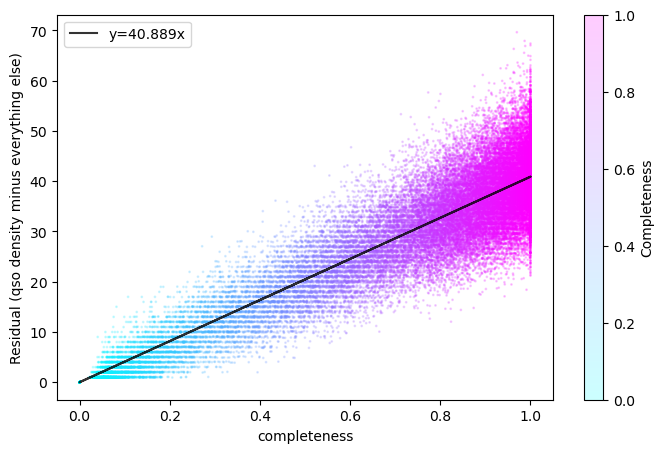

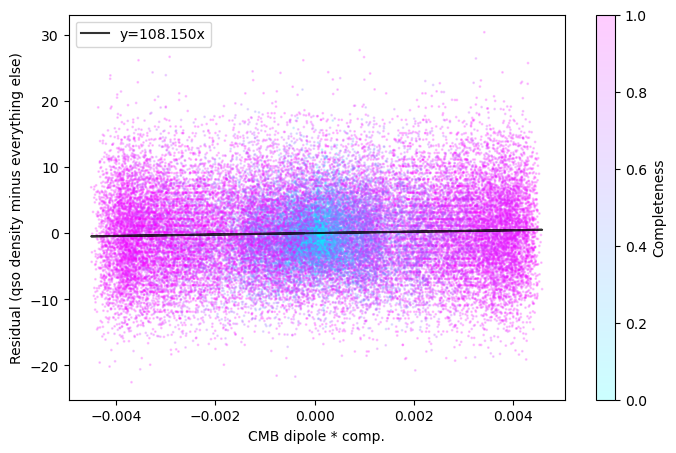

In [16]:
lstsqfit(full_vector=False, fit_everything=False, plots=True)

$\Rightarrow$ best fits barely change $\Rightarrow$ feature maps have little impact

### fit to the full dipole vector, without the feature maps

In [17]:
# check out three orthogonal dipole maps
template_amps = np.column_stack((np.zeros(3), np.diag(np.ones(3))))  # first column for the monopole
template_maps = np.array([dipole_map(amps) for amps in template_amps])

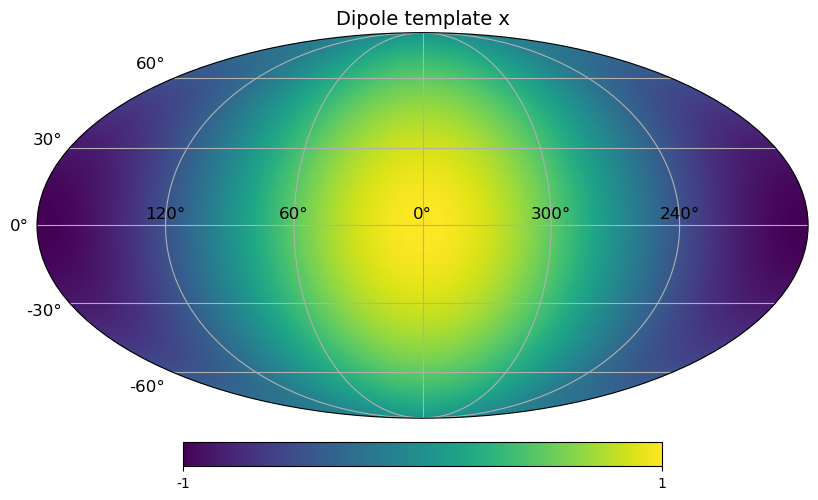

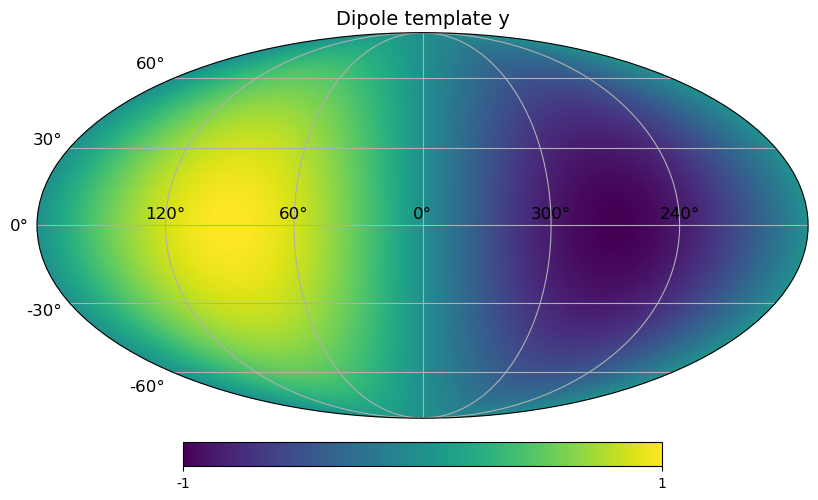

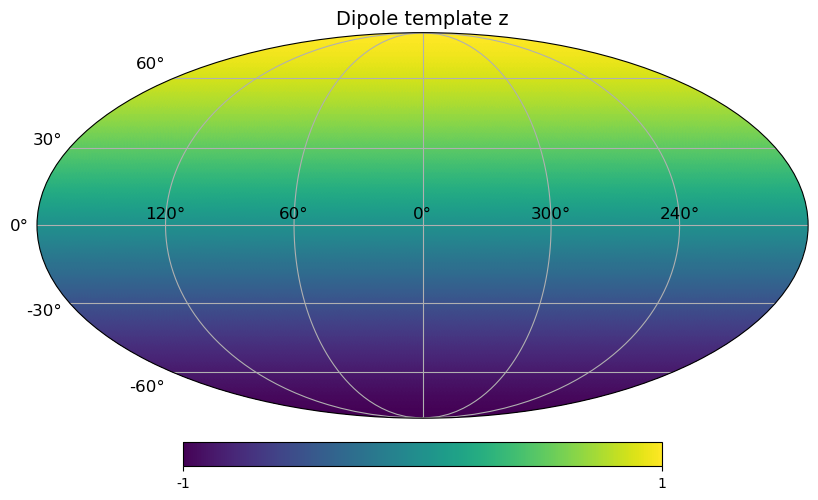

In [18]:
coords = ['x', 'y', 'z']
for i, map_ in enumerate(template_maps):
    tools.plot_map(map_, title='Dipole template '+coords[i], min=-1.0, max=1.)

fitting to full dipole vector

results -
feature:        	best fit:       	std err:        	
completeness    	40.939455       	0.036043        	
dipole x * comp.	-0.765453       	0.057414        	
dipole y * comp.	-1.669038       	0.069682        	
dipole z * comp.	-0.794876       	0.065783        	

amp = 2.000859
direction:  <SkyCoord (ICRS): (ra, dec) in deg
    (245.36290716, -23.40747278)>


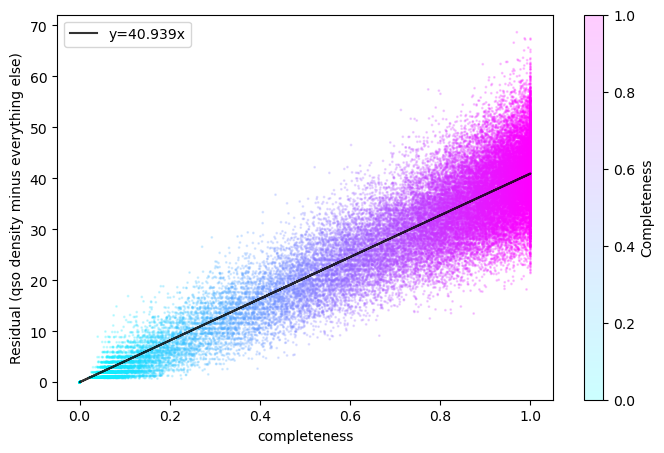

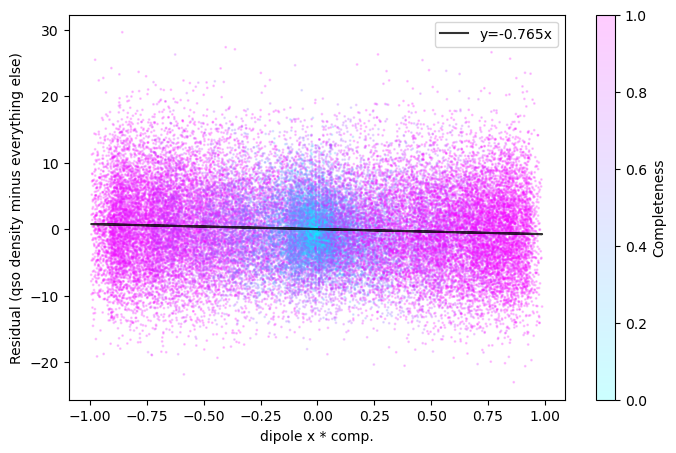

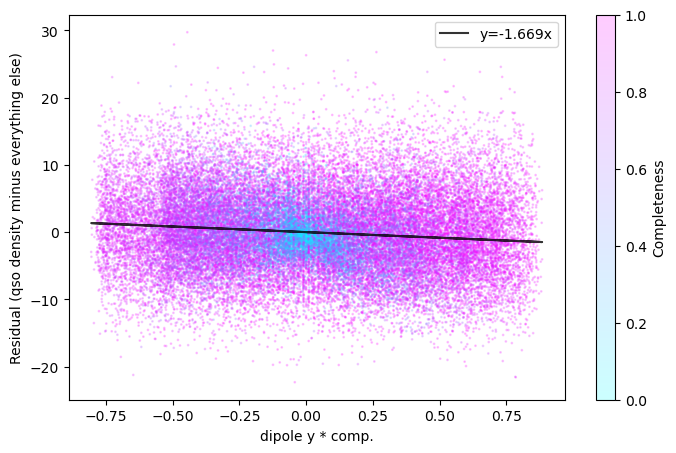

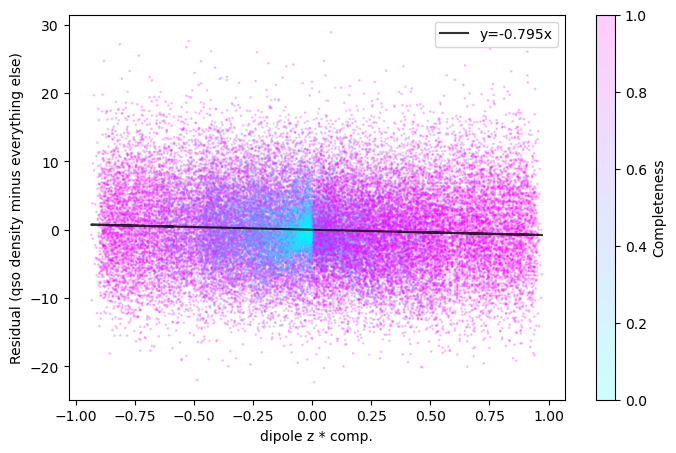

In [19]:
lstsqfit(full_vector=True, fit_everything=False, plots=True)

### fit to the full dipole vector, with the four feature maps

In [20]:
lstsqfit(full_vector=True, fit_everything=True)

fitting to full dipole vector
including feature maps in the fit

results -
feature:        	best fit:       	std err:        	
completeness    	41.103655       	0.041711        	
dipole x * comp.	-0.761895       	0.057417        	
dipole y * comp.	-1.678591       	0.069704        	
dipole z * comp.	-0.798837       	0.065852        	
dust            	0.005070        	0.001538        	
stars           	0.000017        	0.000009        	
m10             	-0.005947       	0.000768        	
mcs             	0.000122        	0.000172        	

amp = 2.009068
direction:  <SkyCoord (ICRS): (ra, dec) in deg
    (245.58721087, -23.42940824)>


### fit to the full dipole vector, only where completeness > 0.9

In [21]:
idx_clean = np.where(selfunc > 0.9)

fitting to full dipole vector

results -
feature:        	best fit:       	std err:        	
completeness    	41.201090       	0.051505        	
dipole x * comp.	-0.348752       	0.092519        	
dipole y * comp.	-0.520362       	0.120259        	
dipole z * comp.	-0.028228       	0.114224        	

amp = 0.627057
direction:  <SkyCoord (ICRS): (ra, dec) in deg
    (236.16960834, -2.58009675)>


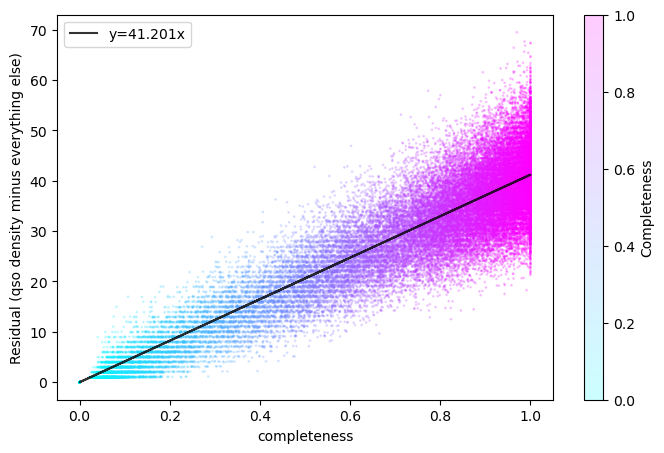

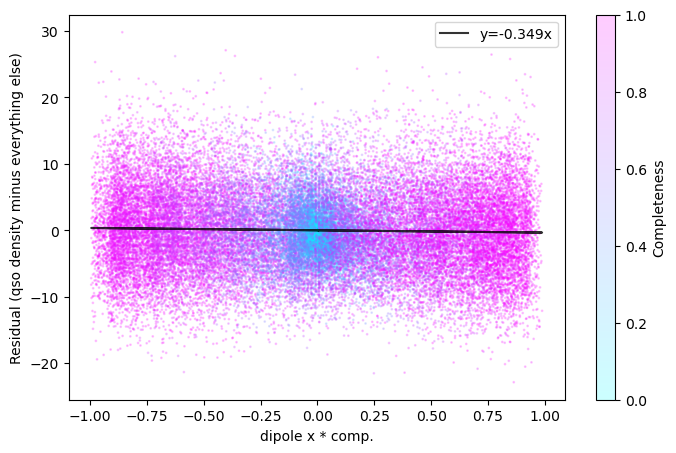

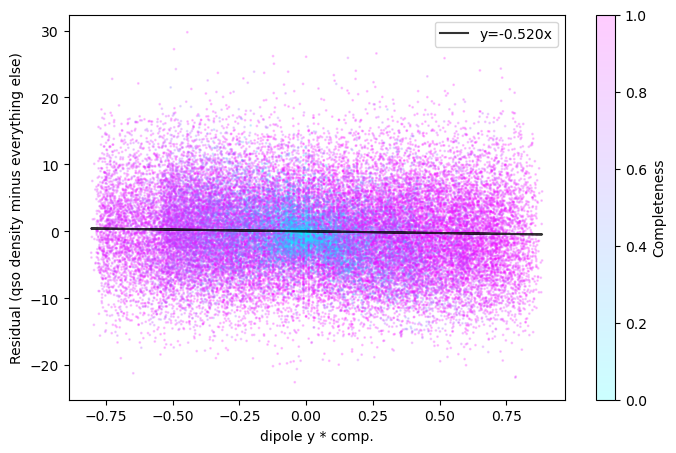

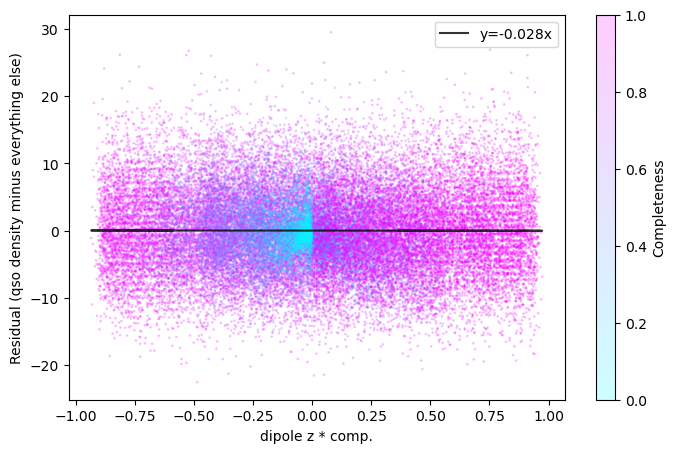

In [22]:
lstsqfit(full_vector=True, fit_everything=False, idx=idx_clean, plots=True)

### fit with the same mask as Secrest ($|b|>30^\circ$)

In [23]:
galactic_mask = tools.get_galactic_mask(blim=30, NSIDE=64, frame='icrs')
map_mc = np.copy(maps_forsel[3]).astype('float')
mcs_mask = (map_mc <= 0)
map_mc[mcs_mask] = np.nan
idx_to_fit = galactic_mask & mcs_mask

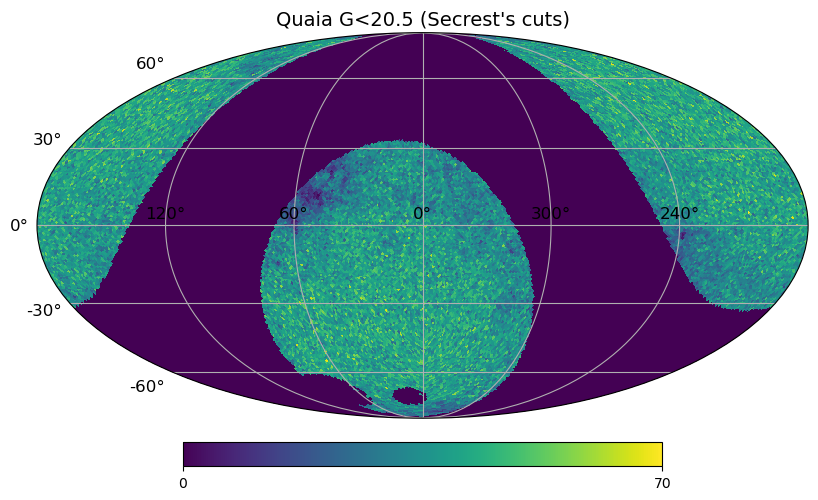

In [24]:
tools.plot_map(map_quaia * idx_to_fit, title=f'Quaia G<{G} (Secrest\'s cuts)')

fitting to full dipole vector

results -
feature:        	best fit:       	std err:        	
completeness    	41.312612       	0.043219        	
dipole x * comp.	-0.596921       	0.068708        	
dipole y * comp.	-0.560177       	0.095137        	
dipole z * comp.	-0.339030       	0.089772        	

amp = 0.886033
direction:  <SkyCoord (ICRS): (ra, dec) in deg
    (223.18112803, -22.49719691)>


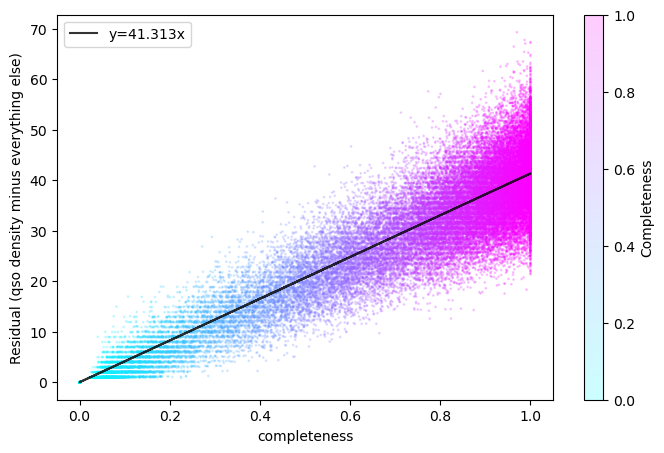

In [ ]:
lstsqfit(full_vector=True, fit_everything=False, plots=True, idx=idx_to_fit)

### double check `healpy.fit_dipole`

#### without selection function

In [ ]:
map_quaia_nodipole, hp_monopole, hp_dipole = hp.remove_dipole(map_quaia.astype('float'), fitval=True)
hp_monopole, hp_dipole

In [ ]:
print(np.linalg.norm(hp_dipole))
direction = hp.vec2dir(hp_dipole)
print(direction)
print(SkyCoord(direction[1], np.pi/2 - direction[0], frame='icrs', unit='rad'))

In [ ]:
cmb_dipdir.icrs

#### with selection function

In [ ]:
selfunc_ = np.copy(selfunc)
selfunc_[selfunc==0.] = np.nan
map_quaia_expected = map_quaia.astype(float) / selfunc_
map_quaia_nodipole_sf, hp_monopole_sf, hp_dipole_sf = hp.remove_dipole(map_quaia_expected, fitval=True)
hp_monopole_sf, hp_dipole_sf

In [ ]:
print(np.linalg.norm(hp_dipole_sf))
direction = hp.vec2dir(hp_dipole_sf)
print(direction)
print(SkyCoord(direction[1], np.pi/2 - direction[0], frame='icrs', unit='rad'))